In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import time
import math

from numpy import array
from numpy.random import seed
from matplotlib import pyplot as plt

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten
from keras.layers import concatenate

from keras.optimizers import SGD

from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm

from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from wordcloud import WordCloud, STOPWORDS

Using TensorFlow backend.


# Collect the data from .CSV file

Once we have collected a nice dataset where labels and streams are connected, we are in a position to figure out how to extract valuable information from them and even create predictive models.

In [2]:
labels_2018_df = pd.read_csv('input/label_names_2018.csv')

videos_df = pd.read_csv('yt8m_data.csv')
videos_df_2 = pd.read_csv('yt8m_data-2.csv')
videos_df_3 = pd.read_csv('yt8m_data-3.csv')
videos_df = pd.concat([videos_df, videos_df_2],ignore_index=True)
videos_df = pd.concat([videos_df, videos_df_3],ignore_index=True)

In [3]:
display(videos_df.tail())
videos_df.describe()

,Unnamed: 0,creator,duration,id,labels,ladder,title,views
3060,1016,NaN,244.0,Zvbw963V5bQ,"[31, 40, 47]","[{'160 - 244x144 (DASH video)': 108.0}, {'133 ...",Coldplay Sparks on piano with GloKeys,1221.0
3061,1017,NaN,276.0,Zw-wymfA3eM,"[2, 30, 55]","[{'160 - 256x144 (144p)': 111.057}, {'133 - 42...",125er Saisonstart 2015 NRW | YoungRider125cc,42647.0
3062,1018,NaN,338.0,ZzUohnlCjyU,"[0, 1, 5, 928]","[{'160 - 192x144 (144p)': 123.503}, {'133 - 32...",todos los personajes de mario bros nuestra inf...,7699.0
3063,1019,Jimmy Eat World,232.0,_0BPYA8bzWw,"[25, 2313]","[{'160 - 192x144 (144p)': 84.642}, {'133 - 320...",Stargate fun!,2513.0
3064,1020,NaN,173.0,636t-Y2Kgak,"[2, 7, 95, 179, 252]","[{'160 - 192x144 (144p)': 110.844}, {'133 - 32...",suzuki ignis 4x4 new edition (2^ parte),11184.0


,Unnamed: 0,duration,views
count,3065.000000,3065.000000,3.065000e+03
mean,510.349429,254.280914,6.054143e+04
std,295.005645,99.548680,4.924978e+05
min,0.000000,119.000000,1.011000e+03
25%,255.000000,173.000000,2.206000e+03
50%,510.000000,234.000000,5.015000e+03
75%,766.000000,315.000000,1.580400e+04
max,1028.000000,501.000000,1.527585e+07


In [4]:
display(labels_2018_df.head())
labels_2018_df.shape

,label_id,label_name
0,0,Game
1,1,Vehicle
2,2,Video game
3,3,Concert
4,4,Car


(3862, 2)

## Prepare the output ladders

In [5]:
ladder_array = []

# Extract the ladders from the data frame to create the output layer
for video in videos_df['ladder']:
    ladder = {}
    video = video.replace('[','')
    video = video.replace(']','')
    video = video.replace('}','')
    data = np.array(video.split(','))

    for step in data:
        try:
            resolution = int(step.split('x')[1].split(' ')[0])
            bitrate = float(step.split(':')[1])

            if (resolution in [144,240,360,480,720,1080]):
                ladder[resolution] = bitrate
        except:
            print('There was an error')
    ladder_array.append(ladder)
# Create a new dataframe with the coresponding ladders
ladders_df = pd.DataFrame(ladder_array)

# Remove the rows of the input data frame with non relevant data to avoid bias in the predictions
display(ladders_df.describe())
print("Prior to dropna")
videos_df = videos_df.fillna(0)
videos_df = pd.concat([videos_df, ladders_df], axis=1)
videos_df = videos_df.dropna()

# Remove also thos rows from the output
ladders_df = ladders_df.dropna()
ladders_df = ladders_df.fillna(0)

# Print the relevant statistics before the scaling
display(ladders_df.describe())
display(ladders_df.head(5))
print("Prior to scaling")

# Scale the 
minmax_scale_ladders = MinMaxScaler(feature_range=(0, 1))
ladders_df = pd.DataFrame(minmax_scale_ladders.fit_transform(ladders_df.values).astype('float32'),
                          columns=['144','240','360','480','720','1080'],index=videos_df.index)
display(ladders_df.head(5))
print("After scaling")

There was an error


,144,240,360,480,720,1080
count,2934.000000,2877.000000,2586.000000,2371.000000,1446.000000,613.000000
mean,113.088060,249.512905,529.776716,1022.954134,2111.720156,4054.863305
std,12.895496,22.434632,152.052850,215.820715,509.026852,982.122269
min,29.296000,50.782000,39.234000,63.441000,104.165000,296.000000
25%,110.454500,246.157000,455.387250,984.237500,2055.631000,4031.785000
50%,112.606000,248.601000,605.059000,1114.253000,2223.431000,4185.881000
75%,115.459250,253.036000,610.309750,1155.000000,2296.754000,4331.250000
max,271.238000,465.114000,3687.987000,3700.576000,5530.929000,6923.248000


Prior to dropna


,144,240,360,480,720,1080
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,112.139182,249.667894,552.017782,1040.944796,2094.073726,4046.679792
std,7.942346,22.222195,180.983106,207.885498,488.911127,980.582740
min,44.011000,85.723000,62.853000,101.575000,176.150000,296.000000
25%,110.388000,246.206000,502.937000,1102.199000,2045.852000,4028.441000
50%,111.822000,248.738000,606.674000,1115.158000,2225.716000,4181.220000
75%,114.400500,253.486000,612.569500,1155.000000,2310.000000,4331.250000
max,166.731000,366.545000,3687.987000,2460.943000,3497.727000,6902.853000


,144,240,360,480,720,1080
5,114.595,252.184,415.080,907.909,2041.606,6902.853
15,109.656,248.629,606.433,1108.048,2222.436,4156.889
23,112.922,254.094,606.459,1111.571,2245.235,4156.952
27,121.129,259.802,410.134,791.269,1405.160,3042.019
30,112.620,251.179,616.550,1125.195,3378.174,5551.100


Prior to scaling


,144,240,360,480,720,1080
5,0.575163,0.592763,0.097162,0.341758,0.561618,1.000000
15,0.534917,0.580104,0.149948,0.426586,0.616059,0.584376
23,0.561530,0.599565,0.149955,0.428079,0.622922,0.584386
27,0.628406,0.619891,0.095798,0.292322,0.370008,0.415632
30,0.559069,0.589185,0.152738,0.433853,0.964007,0.795401


After scaling


In [6]:
videos_df

,Unnamed: 0,creator,duration,id,labels,ladder,title,views,144,240,360,480,720,1080
5,5,0,145.0,-j989rqetQE,"[4, 9, 10, 37, 1523]","[{'160 - 256x144 (144p)': 114.595}, {'133 - 42...",Blues Guitar Epiphone Riviera!!! (slide playi...,2452.0,114.595,252.184,415.080,907.909,2041.606,6902.853
15,15,0,485.0,wo-Rbbuy8rk,"[2, 7, 83, 208, 262, 1134]","[{'160 - 256x144 (144p)': 109.656}, {'133 - 42...",CAT D6K LGP at Zielger,6820.0,109.656,248.629,606.433,1108.048,2222.436,4156.889
23,23,0,248.0,FKYxkx1vajM,[3],"[{'160 - 256x144 (144p)': 112.922}, {'133 - 42...",KRISTAL MEMBURU IMPIAN AKUSTIK,3673.0,112.922,254.094,606.459,1111.571,2245.235,4156.952
27,27,0,147.0,jarWs1a-drU,[8],"[{'160 - 256x144 (144p)': 121.129}, {'133 - 42...",Robin vs Karton | 1/8 | SMART SESSION 2012,2403.0,121.129,259.802,410.134,791.269,1405.160,3042.019
30,30,0,120.0,GS4tuyum1FU,"[0, 1, 124, 153, 317]","[{'160 - 230x144 (144p)': 112.62}, {'133 - 384...",End of Round Screen Glitch Looks Awesome,1689.0,112.620,251.179,616.550,1125.195,3378.174,5551.100
34,34,0,154.0,WVn8ckzvdOk,"[31, 40, 47, 57]","[{'160 - 256x144 (144p)': 112.38}, {'133 - 426...",Shot at the Night by The Killers-Piano Cover,10638.0,112.380,245.717,314.265,649.971,1292.294,2696.197
37,37,0,383.0,WborWpqHw8E,"[4, 13, 164]","[{'160 - 256x144 (DASH video)': 108.0}, {'133 ...",Baker Marching Band Halftime Show 2013 against...,1534.0,108.000,242.000,606.074,1155.000,2310.000,4331.250
47,47,Mr. Probz,381.0,XgcuOXhDKWs,[284],"[{'160 - 256x144 (144p)': 112.788}, {'133 - 42...",TUFFI BERGEGGI GOPRO,6159.0,112.788,249.641,607.835,1126.660,2228.082,4190.650
48,48,0,276.0,3Nb2ZTNKZuE,"[0, 1, 35, 85]","[{'160 - 256x144 (144p)': 111.233}, {'133 - 42...",GTA5 Online - Ep 4 - JaltoidGames!,13758.0,111.233,248.354,609.723,1113.695,3325.586,5529.911
55,55,0,166.0,eJoDnjilW74,[25],"[{'160 - 256x144 (144p)': 110.694}, {'133 - 42...",300: Vzestup říše (2014) CZ HD trailer č.2,9837.0,110.694,256.877,604.290,1111.531,2210.941,4127.486


## Prepare categorical data to make embeddings

In the _labels_ colum from the videos_df DataFrame we can observe that label data from YT8M dataset comes as arrays of different lengths. We need to homogeneize them in order to pass them to Keras' embedding layer. The parameter max_length has been set to 15 in a somewhat arbitrary manner just to make sure that all videos have enough slots to pass their label indexes.

In [7]:
labels_array = []
max_labels_number = 15
labels_df = pd.DataFrame(columns=['id', '0','1','2','3','4','5','6','7','8','9','10','11','12','13','14'])
for video in videos_df['labels']:
    video = video.replace('[','')
    video = video.replace(']','')
    data = np.array(video.split(','),dtype='int')

    if len(data) < max_labels_number:
        extension = np.zeros(max_labels_number - len(data))
        data = np.concatenate((data, extension), axis=0)
    labels_array.append(data)

labels_df = pd.DataFrame(labels_array,dtype='int32',index=videos_df.index).dropna()

display(labels_df)
labels_df.shape

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
5,4,9,10,37,1523,0,0,0,0,0,0,0,0,0,0
15,2,7,83,208,262,1134,0,0,0,0,0,0,0,0,0
23,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,0,1,124,153,317,0,0,0,0,0,0,0,0,0,0
34,31,40,47,57,0,0,0,0,0,0,0,0,0,0,0
37,4,13,164,0,0,0,0,0,0,0,0,0,0,0,0
47,284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48,0,1,35,85,0,0,0,0,0,0,0,0,0,0,0
55,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(583, 15)

## Count how often different labels appear

In [8]:
label_count_df = pd.DataFrame(labels_df.apply(pd.value_counts))
label_count_df = label_count_df.drop([0])
label_count_df['Total']= label_count_df.sum(axis=1)
label_count_df = label_count_df[label_count_df['Total'] > 5]
label_count_df = label_count_df.sort_values(by=['Total'])

labels_totals_df = pd.DataFrame(columns=['Label','Total'])
labels_totals_df['Total'] = label_count_df['Total']
labels_totals_df = labels_totals_df.sort_values(['Total'])


for label in label_count_df.index:
    total_frequency = labels_2018_df[labels_2018_df['label_id']==label].values[0][1]
    labels_totals_df.at[label, 'Label'] = total_frequency
    
labels_totals_df = labels_totals_df.replace(to_replace=r' ', value='-', regex=True)
display(labels_totals_df.tail(10))
labels_totals_df = pd.DataFrame(labels_totals_df['Total'].values, index=labels_totals_df['Label'].values)
display(labels_totals_df.tail(10))

,Label,Total
20,Trailer-(promotion),21.0
9,Music-video,23.0
6,Animation,27.0
7,Musician,29.0
11,Motorsport,34.0
14,Guitar,48.0
4,Car,48.0
3,Concert,63.0
2,Video-game,64.0
1,Vehicle,76.0


,0
Trailer-(promotion),21.0
Music-video,23.0
Animation,27.0
Musician,29.0
Motorsport,34.0
Guitar,48.0
Car,48.0
Concert,63.0
Video-game,64.0
Vehicle,76.0


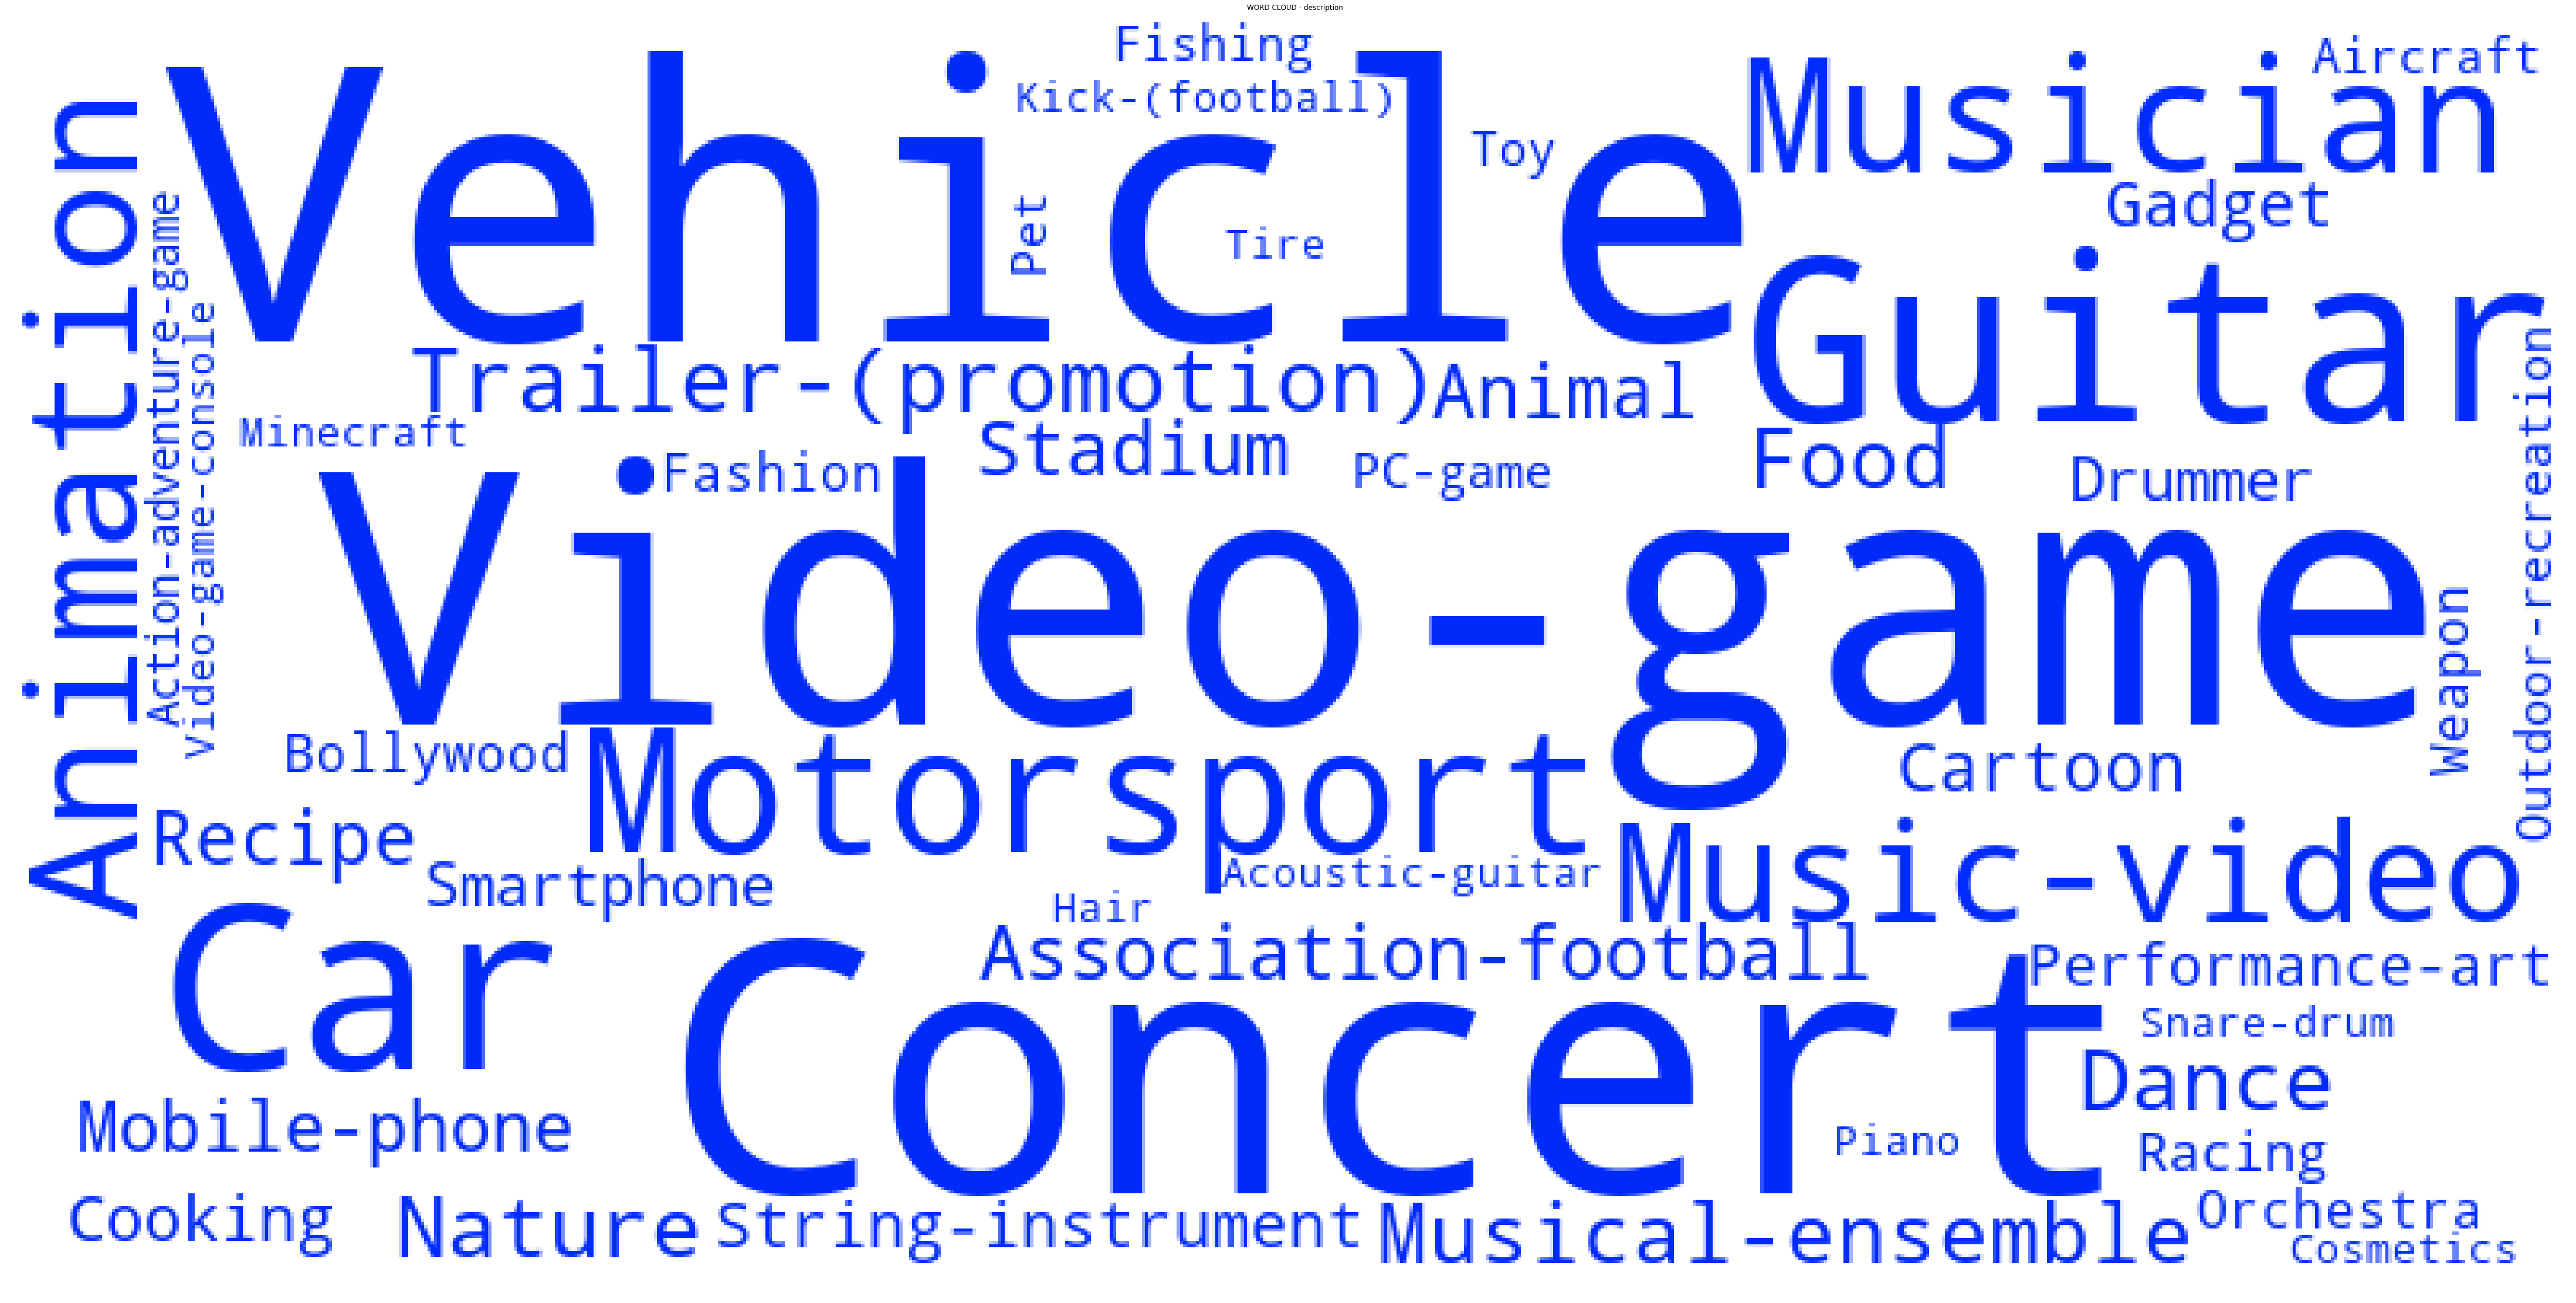

In [9]:
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))

plt.figure(figsize = (80,40))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=1000,
                      max_font_size=120, 
                      collocations=False,
                      random_state=42,
                      width=800, 
                      height=400
                     ).generate_from_frequencies(frequencies=labels_totals_df[0])
#                          ).generate(str(labels_totals_df['Label'].values))

#change the color setting
wordcloud.recolor(color_func = grey_color_func)

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - description")
plt.axis('off')
plt.show()

As explained here (https://www.kdnuggets.com/2015/12/beyond-one-hot-exploration-categorical-variables.html), the labels above can be considered categories to which each of our videos can be associated with. This means that each of the labels assigns the measurement to one of those finite groups, or categories. It is different from ordinal variables in that the distance from one category to another ought to be equal regardless of the number of categories, as opposed to ordinal variables which have some intrinsic ordering.  As an example:

-  Ordinal: low, medium, high
-  Categorical: Georgia, Alabama, South Carolina, … , New York

#### The machine learning algorithms we will later use tend to want numbers, not strings, as their inputs so we need some method of coding to convert them.
To circle back to the problem at hand: we want to code categorical variables into numbers, but we dont't want to be handling an enormous array of zeros. The obvious answer is to just assign an integer to each category (we are assuming we know all of the possible categories up front).  This is called ordinal coding.  It does not add any dimensions to the problem, but implies an order to the variable that may not actually exist.

There is a number of options when it comes to encoding our categorial values (descriptions of 4-7 are taken from statsmodel’s docs):

-  Ordinal: as described above
-  One-Hot: one column per category, with a 1 or 0 in each cell for if the row contained that column’s category
-  Binary: first the categories are encoded as ordinal, then those integers are converted into binary code, then the digits from that binary string are split into separate columns.  This encodes the data in fewer dimensions that one-hot, but with some distortion of the distances.
-  Sum: compares the mean of the dependent variable for a given level to the overall mean of the dependent variable over all the levels. That is, it uses contrasts between each of the first k-1 levels and level k In this example, level 1 is compared to all the others, level 2 to all the others, and level 3 to all the others.
-  Polynomial: The coefficients taken on by polynomial coding for k=4 levels are the linear, quadratic, and cubic trends in the categorical variable. The categorical variable here is assumed to be represented by an underlying, equally spaced numeric variable. Therefore, this type of encoding is used only for ordered categorical variables with equal spacing.
-  Backward Difference: the mean of the dependent variable for a level is compared with the mean of the dependent variable for the prior level. This type of coding may be useful for a nominal or an ordinal variable.
-  Helmert: The mean of the dependent variable for a level is compared to the mean of the dependent variable over all previous levels. Hence, the name ‘reverse’ being sometimes applied to differentiate from forward Helmert coding.

### Embeddings layer

Alternatively, we can make use of Keras' embedding layer to make a projection of our 1014th dimensional space of labels into something more manageable, like (for example) a 50th dimensional universe where the relationships between those labels are already implicitly encoded (although not necessarily explained). Enter the Embeddings (from https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work):

The most common application of this layer is for text processing. Let's see a simple example. Our training set consists only of two phrases:

_Hope to see you soon_

_Nice to see you again_

So we can encode these phrases by assigning each word a unique integer number (by order of appearance in our training dataset for example). Then our phrases could be rewritten as:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Now imagine we want to train a network whose first layer is an embeding layer with those phrases. In this case, we should initialize it as follows:

Embedding(7, 2, input_length=5)

The first argument (7) is the number of distinct words in the training set. The second argument (2) indicates the size of the embedding vectors. The input_length argument determines the size of each input sequence.

Once the network has been trained, we can get the weights of the embedding layer, which in this case will be of size (7, 2) and can be thought as the table used to map integers to embedding vectors:

|   index    |  Embedding |
|------------|------------|
|     0      | [1.2, 3.1] |
|     1      | [0.1, 4.2] |
|     2      | [1.0, 3.1] |
|     3      | [0.3, 2.1] |
|     4      | [2.2, 1.4] |
|     5      | [0.7, 1.7] |
|     6      | [4.1, 2.0] |


So according to these embeddings, our second training phrase will be represented as:

[[0.7, 1.7], [0.1, 4.2], [1.0, 3.1], [0.3, 2.1], [4.1, 2.0]]

##### Embeddings of YT8M labels

In our current case, the inputs supplied to the embeddings layer of our model will be:
-  Number of distinct words: 3861 (the unique labels defined in the labels_2018.csv file)
-  Embedding size: we will arbitrarily limit the dimension to 50
-  input_lenght: we defined the max_length parameter above as 15

In exchange, the Embeddings Keras layer will return us a 3D array with 1015x15x50 elements. 
For each entry of the 1015 videos, we will have a 50th dimensional representation of each of the supplied labels, as opposed to what we would have with, say, one-hot encoding or any other of the above encoding techniques. Once flattened, we will have an array of 750 floating values between 0.0 and 1.0 for each input video in our training set.



## Assemble a Keras model

In [10]:
# Label input: meant to receive sequences of max_labels_number integers, between 1 and 3862.
# Note that we can name any layer by passing it a "name" argument.
label_input = Input(shape=(max_labels_number,), dtype='float32', name='label_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
model = Sequential()
model.add(Embedding(output_dim=15, input_dim=len(labels_2018_df), input_length=max_labels_number))
model.add(Flatten())
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.
output_array = model.predict(labels_df)
embeddings_df = pd.DataFrame(output_array,index=videos_df.index)


resume_embedded_df = pd.concat([embeddings_df,ladders_df], axis=1, sort=False)
display(resume_embedded_df)

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,144,240,360,480,720,1080
5,0.019559,-0.030781,0.021099,-0.005253,-0.019802,0.005508,-0.032557,0.017722,0.016987,0.045914,...,-0.037384,0.011509,-0.01156,0.020931,0.575163,0.592763,0.097162,0.341758,0.561618,1.000000
15,0.019745,-0.027515,0.035356,-0.040167,0.012364,0.046193,0.047408,-0.043260,0.043862,-0.045867,...,-0.037384,0.011509,-0.01156,0.020931,0.534917,0.580104,0.149948,0.426586,0.616059,0.584376
23,0.007485,-0.045976,-0.012017,0.025188,-0.024845,0.007465,-0.045469,0.011213,-0.008892,0.023352,...,-0.037384,0.011509,-0.01156,0.020931,0.561530,0.599565,0.149955,0.428079,0.622922,0.584386
27,-0.015498,0.003154,0.011479,-0.026273,0.016757,0.016381,-0.039977,-0.048138,-0.043982,-0.001775,...,-0.037384,0.011509,-0.01156,0.020931,0.628406,0.619891,0.095798,0.292322,0.370008,0.415632
30,0.019914,0.026042,-0.038488,-0.007709,0.019991,0.045317,-0.027653,-0.023933,-0.012472,0.037900,...,-0.037384,0.011509,-0.01156,0.020931,0.559069,0.589185,0.152738,0.433853,0.964007,0.795401
34,0.016683,0.003544,-0.009676,0.040114,-0.020802,0.021396,0.032631,0.022171,0.022570,-0.018332,...,-0.037384,0.011509,-0.01156,0.020931,0.557114,0.569735,0.069352,0.232433,0.336028,0.363289
37,0.019559,-0.030781,0.021099,-0.005253,-0.019802,0.005508,-0.032557,0.017722,0.016987,0.045914,...,-0.037384,0.011509,-0.01156,0.020931,0.521423,0.556498,0.149849,0.446486,0.642421,0.610767
47,0.034657,0.008669,-0.009583,0.038066,0.037319,0.006920,0.048638,-0.040214,0.028010,-0.023686,...,-0.037384,0.011509,-0.01156,0.020931,0.560438,0.583708,0.150334,0.434474,0.617758,0.589486
48,0.019914,0.026042,-0.038488,-0.007709,0.019991,0.045317,-0.027653,-0.023933,-0.012472,0.037900,...,-0.037384,0.011509,-0.01156,0.020931,0.547767,0.579125,0.150855,0.428979,0.948175,0.792194
55,-0.008491,0.015680,0.026946,-0.040753,-0.039175,-0.038387,-0.017602,-0.004370,0.041883,0.049719,...,-0.037384,0.011509,-0.01156,0.020931,0.543375,0.609475,0.149356,0.428062,0.612598,0.579926


At this point, we feed into the model our auxiliary input data by concatenating it with the LSTM output:

In [11]:
%pylab inline

# https://blog.bioturing.com/2018/06/14/principal-component-analysis-explained-simply/

X_tsne_embeddings = TSNE(learning_rate=10,n_components=3, perplexity=5).fit_transform(embeddings_df)
X_tsne_ladders = TSNE(learning_rate=10, n_components=3, perplexity=5).fit_transform(ladders_df)
X_tsne_ladders_embeddings = TSNE(learning_rate=10, n_components=3, perplexity=5).fit_transform(resume_embedded_df)
X_pca_embeddings = PCA(n_components=3).fit_transform(embeddings_df)
X_pca_ladders = PCA(n_components=3).fit_transform(ladders_df)
X_pca_ladders_embeddings = PCA(n_components=3).fit_transform(resume_embedded_df)


Populating the interactive namespace from numpy and matplotlib


/home/epicra/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


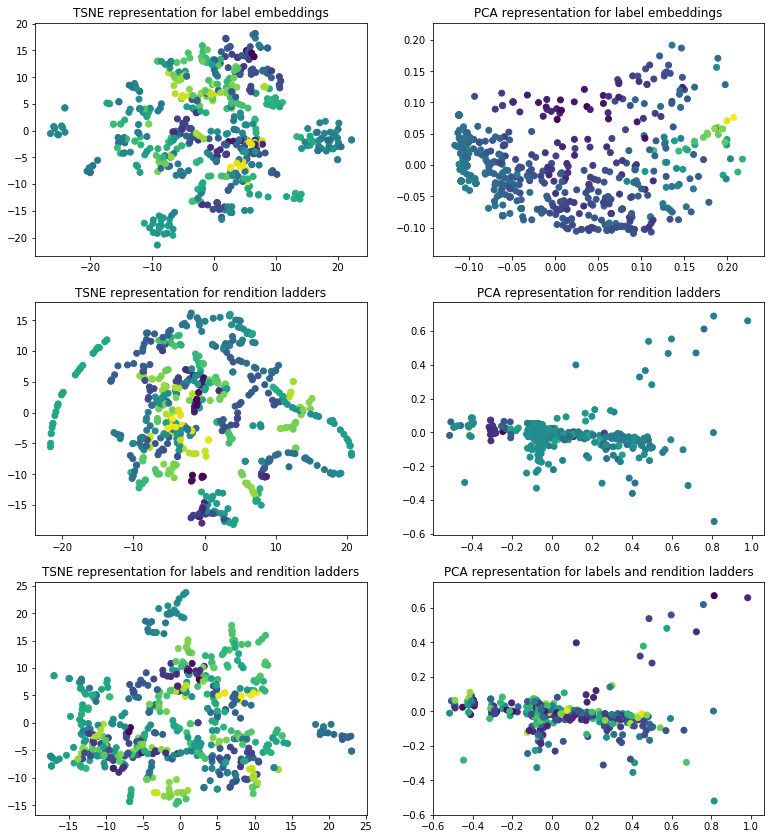

In [12]:
figure(figsize=(15, 10))

subplot(321)
plt.title('TSNE representation for label embeddings')
scatter(X_tsne_embeddings[:, 0], X_tsne_embeddings[:, 1], c=X_tsne_embeddings[:,2])

subplot(323)
plt.title('TSNE representation for rendition ladders')
scatter(X_tsne_ladders[:, 0], X_tsne_ladders[:, 1], c=X_tsne_ladders[:,2])

subplot(325)
plt.title('TSNE representation for labels and rendition ladders')
scatter(X_tsne_ladders_embeddings[:, 0], X_tsne_ladders_embeddings[:, 1], c=X_tsne_ladders_embeddings[:,2])

subplot(322)
plt.title('PCA representation for label embeddings')
scatter(X_pca_embeddings[:, 0], X_pca_embeddings[:, 1], c=X_pca_embeddings[:,2])

subplot(324)
plt.title('PCA representation for rendition ladders')
scatter(X_pca_ladders[:, 0], X_pca_ladders[:, 1], c=X_pca_ladders[:,2])

subplot(326)
plt.title('PCA representation for labels and rendition ladders')
scatter(X_pca_ladders_embeddings[:, 0], X_pca_ladders_embeddings[:, 1], c=X_pca_ladders_embeddings[:,2])


plt.subplots_adjust(bottom=0.1, right=0.8, top=1.2)


## Number of embeddings dimensions: 5

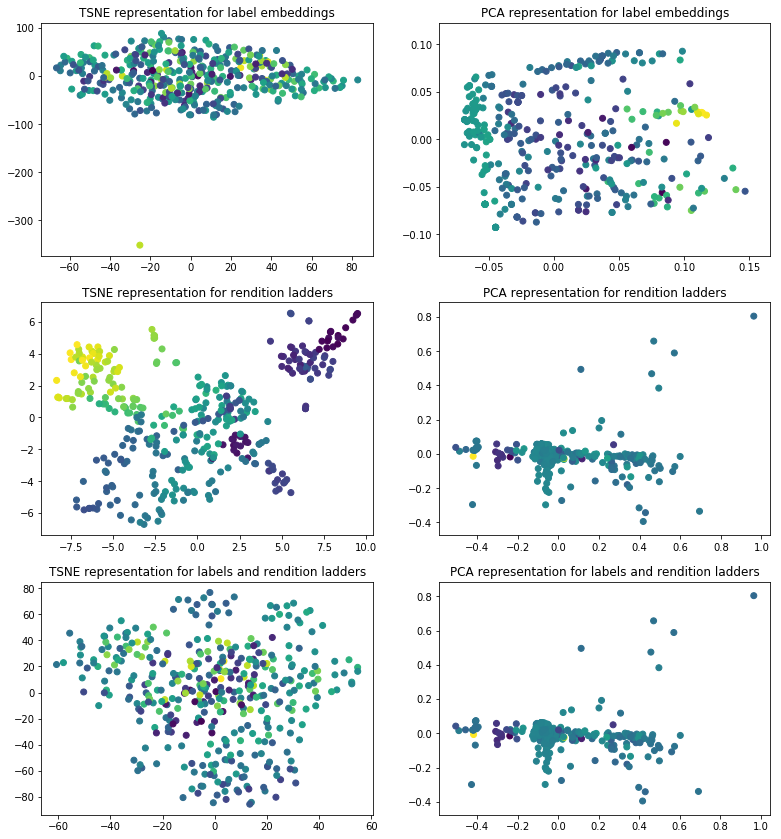

## Number of embeddings dimensions: 12

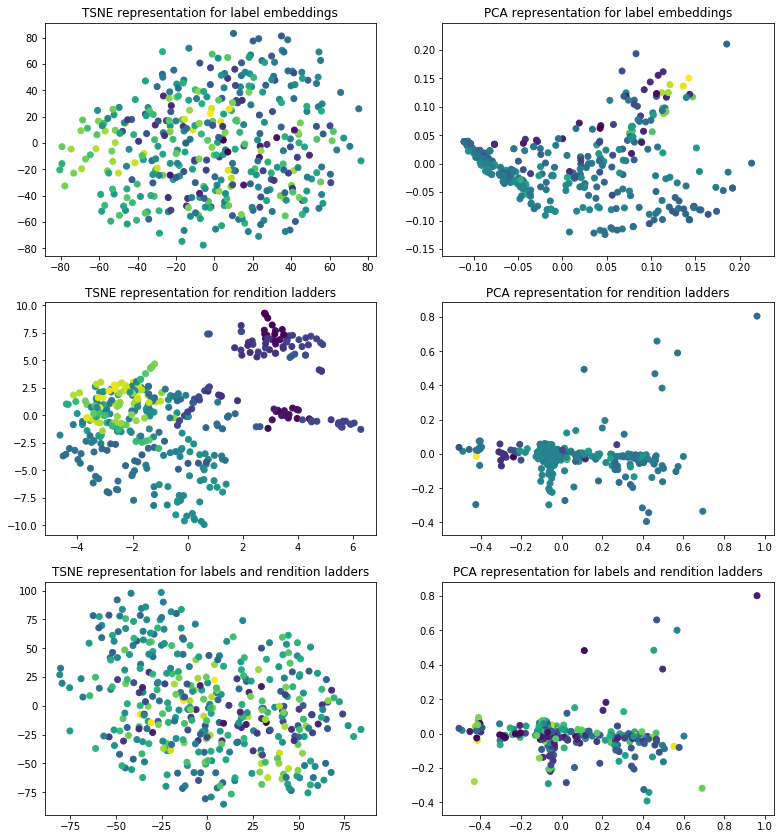

## Number of embeddings dimensions: 15

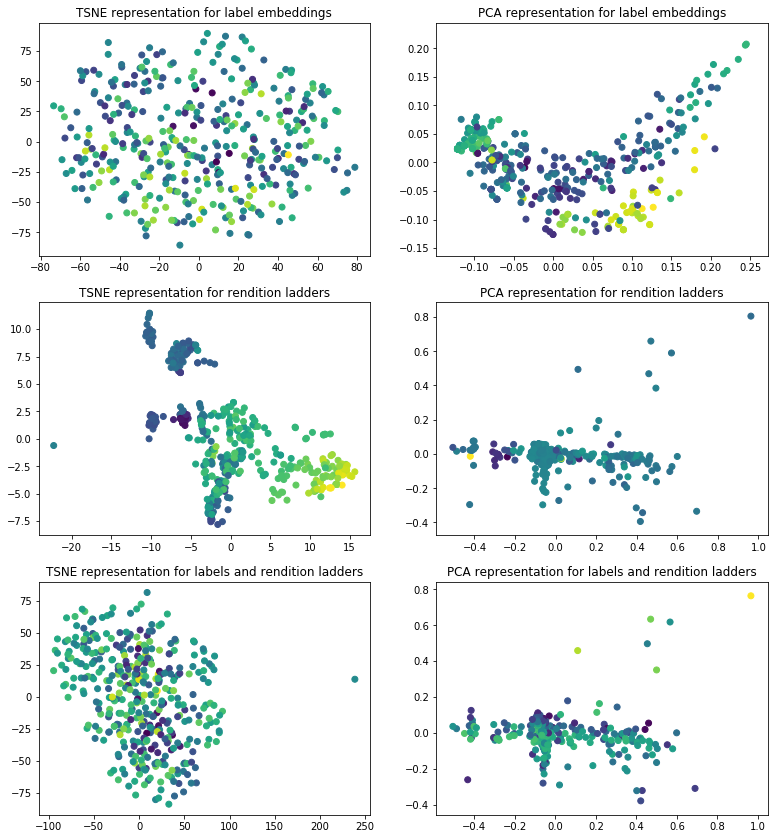

## Number of embeddings dimensions: 20


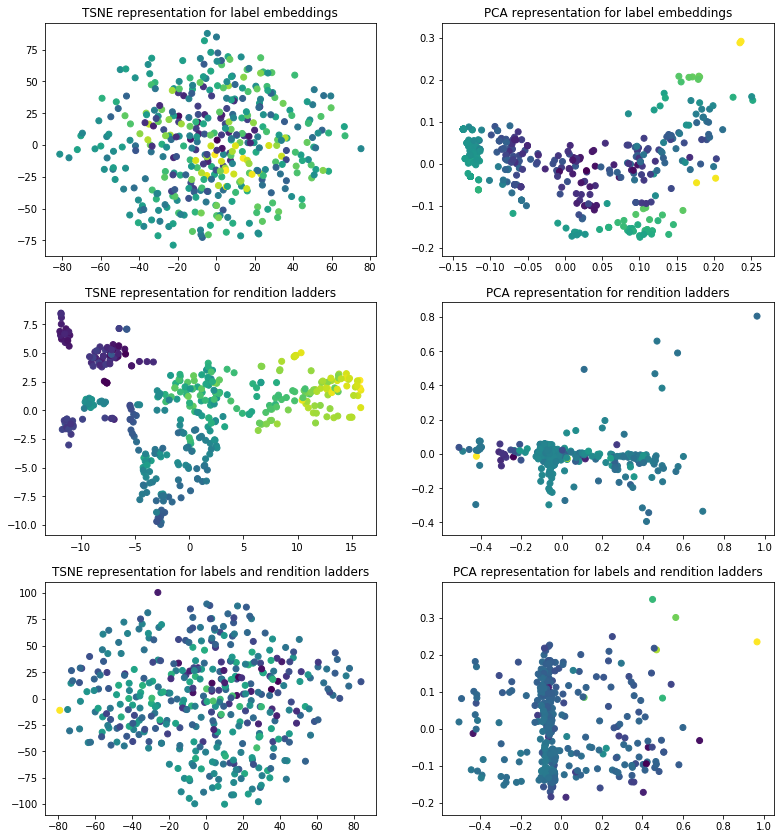

In [13]:
labels_2018_df.iloc[1523]

label_id            1553
label_name    The Sims 4
Name: 1523, dtype: object

In [14]:
videos_df

,Unnamed: 0,creator,duration,id,labels,ladder,title,views,144,240,360,480,720,1080
5,5,0,145.0,-j989rqetQE,"[4, 9, 10, 37, 1523]","[{'160 - 256x144 (144p)': 114.595}, {'133 - 42...",Blues Guitar Epiphone Riviera!!! (slide playi...,2452.0,114.595,252.184,415.080,907.909,2041.606,6902.853
15,15,0,485.0,wo-Rbbuy8rk,"[2, 7, 83, 208, 262, 1134]","[{'160 - 256x144 (144p)': 109.656}, {'133 - 42...",CAT D6K LGP at Zielger,6820.0,109.656,248.629,606.433,1108.048,2222.436,4156.889
23,23,0,248.0,FKYxkx1vajM,[3],"[{'160 - 256x144 (144p)': 112.922}, {'133 - 42...",KRISTAL MEMBURU IMPIAN AKUSTIK,3673.0,112.922,254.094,606.459,1111.571,2245.235,4156.952
27,27,0,147.0,jarWs1a-drU,[8],"[{'160 - 256x144 (144p)': 121.129}, {'133 - 42...",Robin vs Karton | 1/8 | SMART SESSION 2012,2403.0,121.129,259.802,410.134,791.269,1405.160,3042.019
30,30,0,120.0,GS4tuyum1FU,"[0, 1, 124, 153, 317]","[{'160 - 230x144 (144p)': 112.62}, {'133 - 384...",End of Round Screen Glitch Looks Awesome,1689.0,112.620,251.179,616.550,1125.195,3378.174,5551.100
34,34,0,154.0,WVn8ckzvdOk,"[31, 40, 47, 57]","[{'160 - 256x144 (144p)': 112.38}, {'133 - 426...",Shot at the Night by The Killers-Piano Cover,10638.0,112.380,245.717,314.265,649.971,1292.294,2696.197
37,37,0,383.0,WborWpqHw8E,"[4, 13, 164]","[{'160 - 256x144 (DASH video)': 108.0}, {'133 ...",Baker Marching Band Halftime Show 2013 against...,1534.0,108.000,242.000,606.074,1155.000,2310.000,4331.250
47,47,Mr. Probz,381.0,XgcuOXhDKWs,[284],"[{'160 - 256x144 (144p)': 112.788}, {'133 - 42...",TUFFI BERGEGGI GOPRO,6159.0,112.788,249.641,607.835,1126.660,2228.082,4190.650
48,48,0,276.0,3Nb2ZTNKZuE,"[0, 1, 35, 85]","[{'160 - 256x144 (144p)': 111.233}, {'133 - 42...",GTA5 Online - Ep 4 - JaltoidGames!,13758.0,111.233,248.354,609.723,1113.695,3325.586,5529.911
55,55,0,166.0,eJoDnjilW74,[25],"[{'160 - 256x144 (144p)': 110.694}, {'133 - 42...",300: Vzestup říše (2014) CZ HD trailer č.2,9837.0,110.694,256.877,604.290,1111.531,2210.941,4127.486
